# Prediction of closing price for multiple stocks
### The goal is to predict the daily closing price of Intel and AMD by predicting `n` future days (`forward_days`), using as input the `m` past days (`look_back`).

In [1]:
import pandas as pd #create clean and convenient dataframes for storing stock data
import numpy as np #quickly perform calculations on pandas dataframes
import matplotlib.pyplot as plt #plotting/visualizing data
from keras.models import Sequential #using a sequential model since the data is one-dimensional
from keras.layers import LSTM, Dense #the layers of the LSTM we will need
from sklearn.preprocessing import MinMaxScaler #scale the data to optimize performance of the model
from keras.models import load_model #useful for saving/loading pre-trained models

Using TensorFlow backend.
C:\Users\chris\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\chris\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\chris\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\chris\anaconda3\lib\site-packages\tensorboard\comp

In [2]:
#pip install yfinance

In [3]:
import yfinance as yf

In [4]:
num_companies = 2 #can be changed to however many companies are being used in the analysis
look_back = 40 #how many past days to use for the prediction
forward_days = 10 #how many days to predict
num_periods = 20 #used for training the piecewise predictions

### Downloading the stock data with yfinance

In [31]:
#we will only use data from 2018 onward
df_intel=yf.download("INTC", start="2018-01-01") #download and save intel's historical stock data into a pandas dataframe
#any ticker on yahoo finance (MSFT, TSLA, etc.) can be used as well
df_amd=yf.download("AMD", start="2018-01-01")
companies = [df_intel, df_amd]
companies_names = ["Intel", "AMD"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### We only care about the closing price, so we can drop the other columns.

In [32]:
#removes every column except for Close
df_intel.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)
df_amd.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [33]:
df_intel.head()

,Close
Date,
2018-01-02,46.849998
2018-01-03,45.259998
2018-01-04,44.430000
2018-01-05,44.740002
2018-01-08,44.740002


In [34]:
df_amd.head()

,Close
Date,
2018-01-02,10.98
2018-01-03,11.55
2018-01-04,12.12
2018-01-05,11.88
2018-01-08,12.28


### Visualizing the data

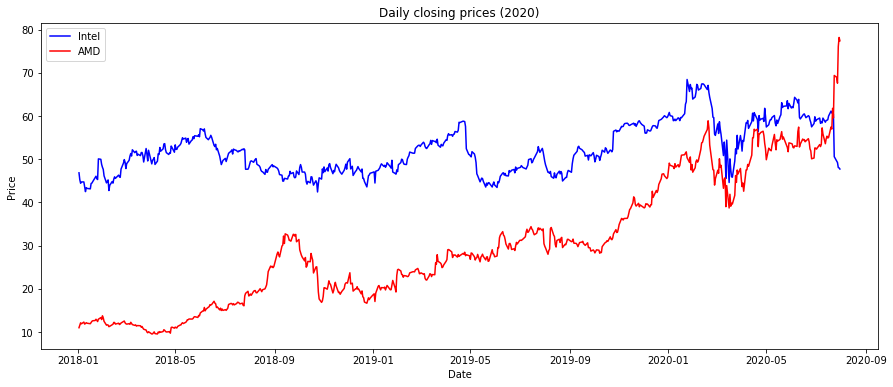

In [35]:
plt.figure(figsize = (15,6))
plt.title("Daily closing prices (2020)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(df_intel, label="Intel", color='b')
plt.plot(df_amd, label="AMD", color='r')
plt.legend()
plt.show()

### Normalizing the data to the range $(0, 1)$

In [36]:
scaler = MinMaxScaler(feature_range=(0,1)) #scale down the data for quicker computation
#also less influence on the model from very small/large numbers

args = [company.values.reshape(company.shape[0],1) for company in companies] #reshape each stock array for the model

In [37]:
array = scaler.fit_transform(np.concatenate((args[0],args[1]), axis=1)) #apply the scaler

### Splitting the data into training and validation sets to fit the model

In [38]:
#split data into training and testing sets
division = len(array) - num_periods*forward_days

array_test = array[division-look_back:]
array_train = array[:division]

In [39]:
#split the data into input/output variables
def processData(data, look_back, forward_days,num_companies,jump=1):
    X,Y = [],[] #create empty lists to store X and Y
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [40]:
#create the train/validate/test splits
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days,num_companies)
y = np.array([list(x.ravel()) for x in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
print(X_train.shape)
print(X_validate.shape)
print(X_test.shape)
print(y_train.shape)
print(y_validate.shape)
print(y_test.shape)
#X values will hyave the shape (sample, timestep, features)
#y values will have the shape (samples, timestep) since there is only one feature

(320, 40, 2)
(81, 40, 2)
(20, 40, 2)
(320, 20)
(81, 20)
(20, 20)


## Training the model

In [43]:
#configuring the hyperparameters of the LSTM
NUM_NEURONS_FirstLayer = 200 #how many neurons are in the first hidden layer
NUM_NEURONS_SecondLayer = 100 #neurons in the second hidden layer
EPOCHS = 50 #how many times to train the model and update its parameters/weights

#Build the model
model = Sequential()

#add two LSTM layers
model.add(LSTM(NUM_NEURONS_FirstLayer, input_shape=(look_back,num_companies), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer, input_shape=(NUM_NEURONS_FirstLayer, 1)))

#add a dense layer to compress the prediction down to one number - the stock price
model.add(Dense(forward_days * num_companies))

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,
                    epochs=EPOCHS, #run through and update the model 50 times
                    validation_data=(X_validate,y_validate), #data held out for validation
                    shuffle=True,
                    batch_size=1,
                    verbose=2)

Train on 320 samples, validate on 81 samples
Epoch 1/50
 - 6s - loss: 0.0089 - val_loss: 0.0047
Epoch 2/50
 - 5s - loss: 0.0053 - val_loss: 0.0041
Epoch 3/50
 - 5s - loss: 0.0050 - val_loss: 0.0041
Epoch 4/50
 - 5s - loss: 0.0042 - val_loss: 0.0036
Epoch 5/50
 - 5s - loss: 0.0038 - val_loss: 0.0042
Epoch 6/50
 - 5s - loss: 0.0042 - val_loss: 0.0035
Epoch 7/50
 - 5s - loss: 0.0037 - val_loss: 0.0041
Epoch 8/50
 - 5s - loss: 0.0039 - val_loss: 0.0036
Epoch 9/50
 - 5s - loss: 0.0037 - val_loss: 0.0033
Epoch 10/50
 - 5s - loss: 0.0037 - val_loss: 0.0033
Epoch 11/50
 - 5s - loss: 0.0035 - val_loss: 0.0040
Epoch 12/50
 - 5s - loss: 0.0036 - val_loss: 0.0035
Epoch 13/50
 - 5s - loss: 0.0034 - val_loss: 0.0038
Epoch 14/50
 - 5s - loss: 0.0035 - val_loss: 0.0034
Epoch 15/50
 - 5s - loss: 0.0033 - val_loss: 0.0038
Epoch 16/50
 - 5s - loss: 0.0033 - val_loss: 0.0031
Epoch 17/50
 - 5s - loss: 0.0034 - val_loss: 0.0040
Epoch 18/50
 - 5s - loss: 0.0033 - val_loss: 0.0028
Epoch 19/50
 - 5s - loss: 0.

### And now we visualize the model's loss overtime:

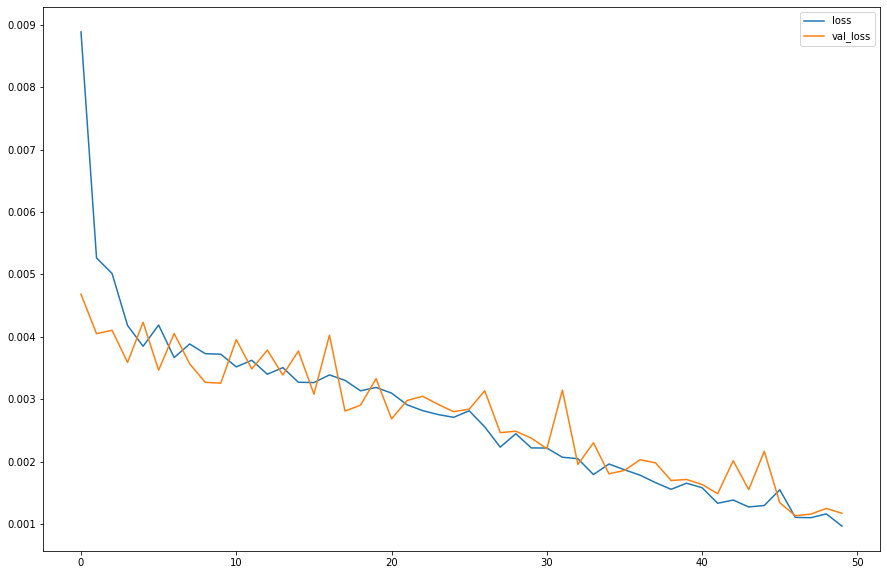

In [44]:
plt.figure(figsize = (15,6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

#### Since the loss did not flatten out, the model may benefit from training with more epochs.

In [ ]:
# #Saving the model
# file_name = 'Redes/several-companies/LSTM_LB{}_FD{}_E{}_F{}_S{}.h5'.format(look_back, forward_days, EPOCHS, NUM_NEURONS_FirstLayer, NUM_NEURONS_SecondLayer)
# model.save(file_name)
# print("Saved model `{}` to disk".format(file_name))

### Performing our predictions on the test set

In [45]:
X_test,y_test = processData(array_test,look_back,forward_days,num_companies,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

Xt = model.predict(X_test) #creates the predictions
Xt.shape

(20, 20)

In [46]:
def do_inverse_transform(output_result,num_companies=num_companies):
    
    #transform to input shape
    original_matrix_format = []
    for result in output_result:
        #do inverse transform
        original_matrix_format.append(scaler.inverse_transform([result[x:x+num_companies] for x in range(0, len(result), num_companies)]))
    original_matrix_format = np.array(original_matrix_format)
    
    #restore to original shape
    for i in range(len(original_matrix_format)):
        output_result[i] = original_matrix_format[i].ravel()

    return output_result

In [47]:
#performs the stepwise predictions for each company, one at a time
def prediction_by_step_by_company(raw_model_output, num_companies):
    matrix_prediction = []
    for i in range(0,num_companies):
        matrix_prediction.append([[list[j] for j in range(i,len(list),num_companies)] for list in raw_model_output]) #appends the predictions to the prediction list
    return np.array(matrix_prediction)

In [48]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(2, 20, 10)

In [49]:
def target_by_company(raw_model_output, num_companies):
    matrix_target = [[] for x in range(num_companies)]
    
    for output in raw_model_output:
        for i in range (num_companies):
            for j in range(0,len(output),num_companies):
                matrix_target[i].append(output[i+j])
    return np.array(matrix_target)

In [50]:
Yt = do_inverse_transform(y_test)

MT = target_by_company(Yt, num_companies)
MT.shape

(2, 200)

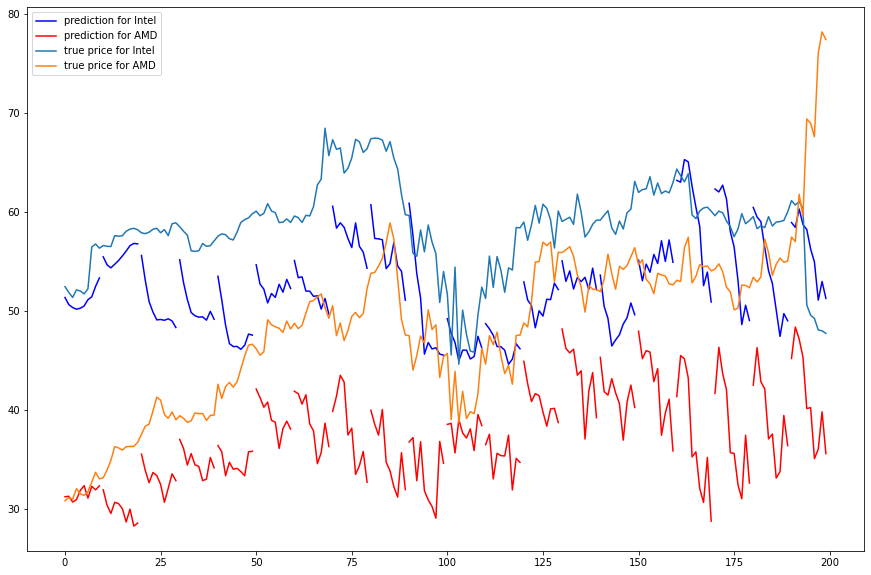

In [51]:
plt.figure(figsize = (15,10))

companies_to_show = [0,1] #which companies to use on the plot
colors=['blue','red'] #colors to use for the predicted prices

#plots the piecewise predictions for each stock
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='prediction for {}'.format(companies_names[id_company])) #only to place the label


for id_company in companies_to_show:
    plt.plot(MT[id_company], label='true price for {}'.format(companies_names[id_company]))

plt.legend(loc='best')
plt.show()

### Using all of the data as testing

In [52]:
X_all,y_all = processData(array,look_back,forward_days,num_companies,forward_days)
y_all = np.array([list(a.ravel()) for a in y_all])

In [53]:
Xt = model.predict(X_all)
Xt.shape

(61, 20)

In [54]:
Xt = do_inverse_transform(Xt)

MP = prediction_by_step_by_company(Xt, num_companies)
MP.shape

(2, 61, 10)

In [55]:
Yt = do_inverse_transform(y_all)

MT = target_by_company(Yt, num_companies)
MT.shape

(2, 610)

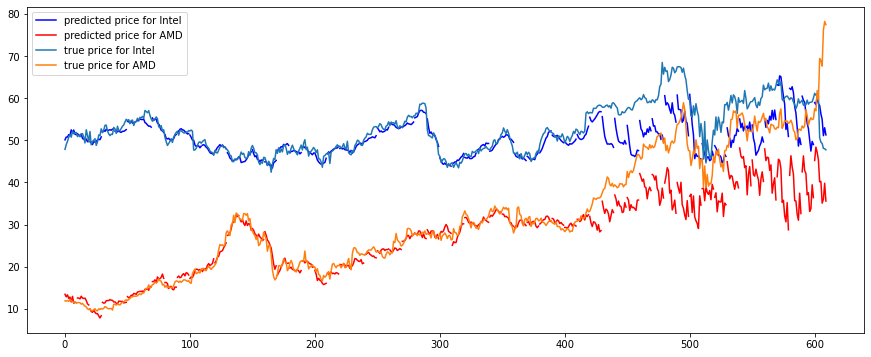

In [56]:
plt.figure(figsize = (15,6))

companies_to_show = [0,1] #select one of [0,1,2,3] to see only one
    
for id_company in companies_to_show:
    for i in range(0,len(MP[id_company])):
        plt.plot([x + i*forward_days for x in range(len(MP[id_company][i]))], MP[id_company][i], color=colors[id_company])
    plt.plot(0,MP[id_company][0][0] ,color=colors[id_company], label='predicted price for {}'.format(companies_names[id_company])) #only to place the label
    
for id_company in companies_to_show:
    plt.plot(MT[id_company], label='true price for {}'.format(companies_names[id_company]))

plt.legend()
plt.show()